# Mini-projet n°1 – Chats ou Chiens ?

## 1- Analyse exploratoire du jeu de données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns # pour faire des beaux affichages
from PIL import Image

### A- Étudier la répartition par race et par type (chat/chien)

Le jeu de données est composé de 7349 lignes.
Chaque ligne a :
- un type : chat ou chien
- une race : 37 races différentes

On commence par créer un dataframe propre.

In [2]:
df = pd.read_csv(# Lecture du fichier list.txt
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",                                         # séparateur = espaces multiples
    comment="#",                                        # ignorer les lignes commençant par #
    header=None,                                        # pas d'en-tête dans les lignes de données
    names=["Image", "CLASS_ID", "SPECIES", "BREED_ID"]  # noms des colonnes
)

# On rajoute des colonnes pour mieux labelliser les données
df["BREED_NAME"] = df["Image"].str.rsplit("_", n=1).str[0]           # Nom de la race
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"})     # Chat ou chien
df["Image"] = df["Image"].apply(lambda x: f"{x}.jpg") # Et on ajoute du chemin complet vers chaque image. Il faut faire attention car les images ne sont pas dans "annotations" mais dans le dossier "images"
print(df.head())

                Image  CLASS_ID  SPECIES  BREED_ID  BREED_NAME SPECIES_NAME
0  Abyssinian_100.jpg         1        1         1  Abyssinian          Cat
1  Abyssinian_101.jpg         1        1         1  Abyssinian          Cat
2  Abyssinian_102.jpg         1        1         1  Abyssinian          Cat
3  Abyssinian_103.jpg         1        1         1  Abyssinian          Cat
4  Abyssinian_104.jpg         1        1         1  Abyssinian          Cat


On peut visualiser le nombre de chiens et de chats :

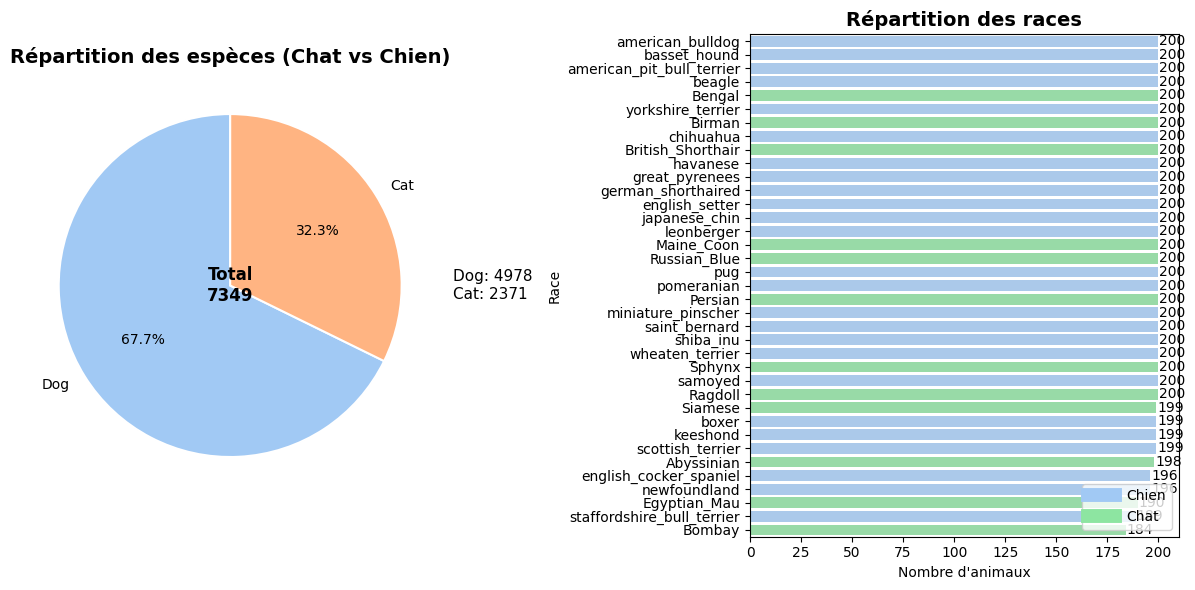

In [6]:
counts_species = df["SPECIES_NAME"].value_counts()
counts_breed = df["BREED_NAME"].value_counts()

species_per_breed = df.drop_duplicates("BREED_NAME").set_index("BREED_NAME")["SPECIES_NAME"] #j'ai voulu faire en sorte d'harmoniser les couleurs entre les deux graphiques mais je n'y arrive pas :'(
colors = {"Dog": sns.color_palette("pastel")[0],"Cat": sns.color_palette("pastel")[2]}
palette = [colors[species_per_breed[breed]] for breed in counts_breed.index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Premier graphique : espèces
colors_species = sns.color_palette("pastel", len(counts_species))
axes[0].pie(counts_species,labels=counts_species.index,autopct="%1.1f%%",startangle=90,colors=colors_species,wedgeprops={"edgecolor": "white", "linewidth": 1.5}) 
axes[0].set_title("Répartition des espèces (Chat vs Chien)", fontsize=14, fontweight="bold")
total = counts_species.sum()
axes[0].text(0, 0, f"Total\n{total}", ha='center', va='center', fontsize=12, fontweight='bold')
species_counts_text = "\n".join([f"{k}: {v}" for k, v in counts_species.items()]) # Ajouter le nombre exact de chaque espèce en légende
axes[0].text(1.3, 0, species_counts_text, fontsize=11, va='center')

# Deuxième graphique : races
sns.barplot(y=counts_breed.index,x=counts_breed.values,hue=counts_breed.index,palette=palette,legend=False,ax=axes[1])
axes[1].set_title("Répartition des races", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Nombre d'animaux")
axes[1].set_ylabel("Race")
for i, v in enumerate(counts_breed.values):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=10)

axes[1].legend(handles=[plt.Line2D([0], [0], color=colors["Dog"], lw=10, label="Chien"),plt.Line2D([0], [0], color=colors["Cat"], lw=10, label="Chat")],loc="lower right") #légendes chien chat en bas à droite 
plt.tight_layout()
plt.show()

on voit clairement que les deux tiers des données sont des chiens, et le tier restant est composé de chats.  
Il y a environ 200 individus de chacune des races, sauf pour les american et english où il y en a environ 400.

### B- Vérifier la cohérence et la qualité des masques de segmentation

Les masques de ségmentation se trouvent dans le dossier *oxford-iiit-pet/annotations/trimaps*.
Chaque image du jeu de données possède un masque associé qui délimite les pixels selon trois classes :
- 1 = Foreground (le corps de l'animal)
- 2 = Background (le fond de l'image)
- 3 = Not classified (on sait pas ce que sait)

Pour vérifier la cohérence et la qualité des masques, on va regarder à la main un petit échantillons, en affichant côte à côte les images et le masque associé.

In [3]:
indices = np.random.choice(df.index, size=5, replace=False) # on choisit les indices des images que l'on va visualiser au hasard
 
img_dir = "oxford-iiit-pet/images/"                 # Chemin du répertoire qui contient les images
mask_dir = "oxford-iiit-pet/annotations/trimaps/"   # Chemin du répertoire qui contient les masques
masks = [f for f in os.listdir(mask_dir) if f.endswith(".png") and not f.startswith("._")] # On ignore les fichiers bizarres qui commencent par "._" qui sont dans le repertoire 

nom de l'image : japanese_chin_75


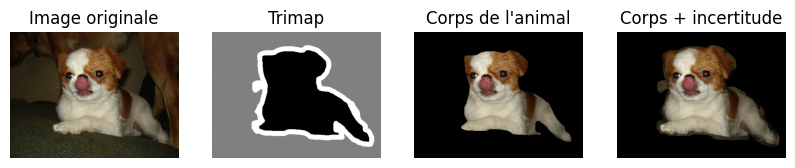

nom de l'image : Persian_31


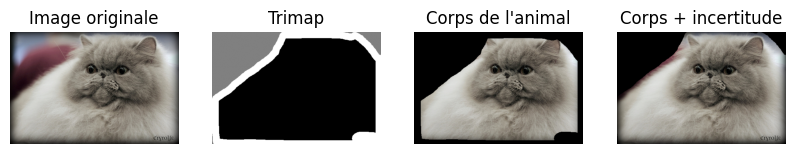

nom de l'image : scottish_terrier_157


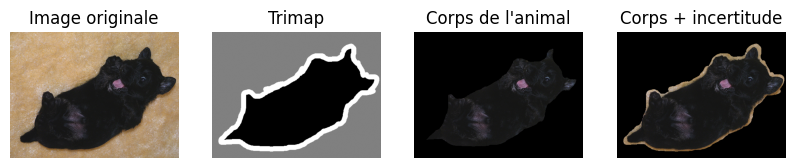

nom de l'image : Bengal_69


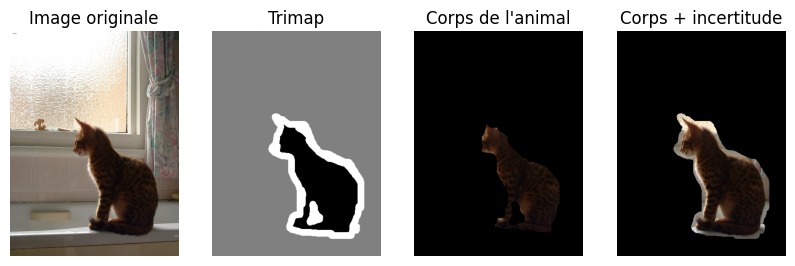

nom de l'image : american_bulldog_67


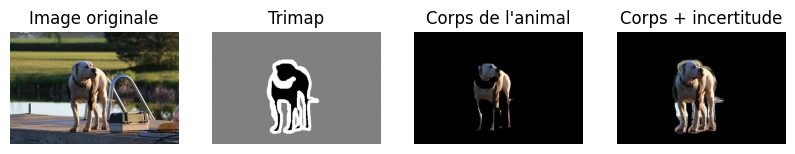

In [ ]:
for indice in indices:
    image = masks[indice]
    name = os.path.splitext(image)[0]
    print("nom de l'image :",name)

    img_path = os.path.join(img_dir, name + ".jpg") # On récupère le path de l'image
    mask_path = os.path.join(mask_dir, image)       # On récupère le path du masque

    img = np.array(Image.open(img_path))            # On récupère les valeurs des pixels dans des np.array 
    mask = np.array(Image.open(mask_path))          # (on utilise la librairie PIL pour faire cela)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) 
    masked_img_moins= img.copy()
    masked_img_moins[mask != 1] = 0   # on garde seulement les pixels 1, on met tout le reste à 0 (en noir)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) et la zone d'incertitude (2)
    masked_img_plus= img.copy()
    masked_img_plus[mask == 2] = 0   # on garde seulement les pixels 1 et 3, on met les pixel 2 à 0 (en noir)

    plt.figure(figsize=(10,5))
    #On affiche nos 4 images
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(masked_img_moins)
    plt.title("Corps de l'animal")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(masked_img_plus)
    plt.title("Corps + incertitude")
    plt.axis("off")

    plt.show()

En parcourant à la main les images, les masques semblent cohérents et de plutot bonne qualité.
Il peut y avoir des confusions lorsque l'animal porte un colier par exemple (indice 4321) mais dans l'ensemble on obtient ce qu'on attend du masque.

### C- Identifier d’éventuels déséquilibres ou biais visuels

Je ne sais pas quoi dire ici

## 2- Classification Binaire

Nous cherchons à distinguer les chats des chiens à partir de leurs photos uniquement.
Pour cela, nous allons mettre en place plusieurs approches, en suivant la méthodologie vue en TP.

Un réseau de neurones convolutionnel (CNN) est particulièrement adapté pour la classification d’images, car il est capable d’apprendre automatiquement des caractéristiques visuelles comme les contours, textures ou motifs propres à chaque classe (ici chats et chiens).
Concrètement, dans ce notebook, nous proposerons trois réseaux de neurones pour réaliser cette tâche de classification :

- un CNN "naïf",
- un CNN entraîné sur un jeu de données augmenté,
- et un réseau utilisant le concept de “Transfer Learning”.

Pour ce dernier, nous utiliserons directement le jeu de données augmenté, puis nous effectuerons une phase de “Fine Tuning” afin d’en améliorer encore les performances.

Nous utiliserons TensorFlow par la suite.

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-12-11 14:32:26.949093: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 14:32:26.995412: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 14:32:30.967175: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Gestion des données d'entrée
Les réseaux de neurones que nous allons mettre en place nécessitent des données d’entrée de taille fixe. Nous commencerons donc par vérifier et contrôler la taille de nos images.

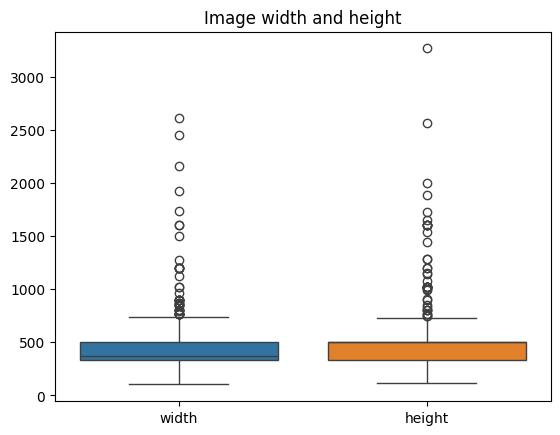

In [8]:
img_size = np.zeros((df.shape[0],2))
for i, image in enumerate(df['Image']) :
    img = img_to_array( load_img(img_dir + image) )
    img_size[i,:] = img.shape[:2]

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

On constate que toutes les images n’ont pas les mêmes dimensions.
Nous allons donc devoir les redimensionner, en imposant une taille uniforme de 150 × 150 pixels.
(Il est possible de choisir une taille plus grande, 400 ou 500 par exemple, mais cela entraînerait des coûts de calcul plus élevés.)

Nous avons maintenant un choix à faire : soit redimensionner toutes les images avant de les séparer en ensembles d’entraînement, de validation et de test, soit séparer d’abord les ensembles puis redimensionner les images.
Pour rester cohérents avec la méthodologie vue en TP, nous choisissons la deuxième approche.

- On sépare en données d'entrainement, de validation et de test :

In [5]:
# On part du DataFrame complet : df qui a comme colonnes : mage, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME
data = df[["Image", "SPECIES_NAME"]].copy() # On crée d’abord une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df = train_test_split(data, test_size=N_train, stratify=data["SPECIES_NAME"])                    # On prend 5000
test_df, validation_df = train_test_split(temp_df, test_size=N_Validation, stratify=temp_df["SPECIES_NAME"])    # On prend 1000  dans ce qu'il reste N_test = N_total - (N_train+N_validation)

print("Train set :", train_df.shape)
print("Validation set :", validation_df.shape)
print("Test set :", test_df.shape)
print("\n----Répartition des catégories----\n")
print("Train :", train_df["SPECIES_NAME"].value_counts())
print("\nValidation :", validation_df["SPECIES_NAME"].value_counts())
print("\nTest :", test_df["SPECIES_NAME"].value_counts())

Train set : (5200, 2)
Validation set : (1000, 2)
Test set : (1149, 2)

----Répartition des catégories----

Train : SPECIES_NAME
Dog    3522
Cat    1678
Name: count, dtype: int64

Validation : SPECIES_NAME
Dog    678
Cat    322
Name: count, dtype: int64

Test : SPECIES_NAME
Dog    778
Cat    371
Name: count, dtype: int64


- On redimensionne nos images :

In [6]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1149 validated image filenames belonging to 2 classes.


Le réseau que nous allons définir est un CNN “naïf”, simple, constitué de plusieurs couches convolutionnelles et de pooling, suivi de couches entièrement connectées. Voici la logique derrière sa construction :
- Couche d’entrée (Input) : elle prend des images de taille (img_width, img_height, 3) — 3 canaux pour les couleurs RGB.
- Couches convolutionnelles (Conv2D) : elles détectent progressivement des motifs de plus en plus complexes dans les images.
- Couches de pooling (MaxPooling2D) : elles réduisent la taille des cartes de caractéristiques tout en conservant les informations importantes, ce qui diminue le coût de calcul et évite le surapprentissage.
- Couches denses (Dense) : après avoir aplati les cartes de caractéristiques avec Flatten(), ces couches permettent au réseau d’apprendre des combinaisons non linéaires pour la classification finale.
- Dropout : cette couche de régularisation permet de réduire le risque de surapprentissage en désactivant aléatoirement certaines neurones pendant l’entraînement.
- Couche de sortie : une seule unité avec une activation sigmoid, adaptée à la classification binaire (chat ou chien).

On fait une fonction car on aura besoin d'initialiser un réseau à nouveau, ça économise des lignes :)

The model we define is composed of 3 convolution blocks with the following form:  
* A $\texttt{Conv2D}$ layer with $3\times3$ filters and a $\texttt{Relu}$ activation function.<br>
  The first layer has 32 convolution filters, the second 64, and the third 96.  
* A $\texttt{MaxPooling}$ layer with a $2\times2$ window.

Followed by:  
* A $\texttt{Flatten}$ layer.  
* A $\texttt{Dense}$ layer with 64 neurons and a $\texttt{Relu}$ activation function.  
* A $\texttt{Dropout}$ layer with a 50% drop rate.  
* A $\texttt{Dense}$ layer with 1 neuron and a $\texttt{sigmoid}$ activation function.


In [25]:
def cnn_simple(nom):
    cnn = Sequential(name=nom)
    cnn.add(Input(shape=(img_width,img_height,3)))
    cnn.add(Conv2D(32, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Conv2D(64, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Conv2D(96, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Flatten())
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid'))
    return cnn

In [26]:
cnn_naif=cnn_simple("cnn_naif")
cnn_naif.summary()                  # Affichage de nos couches et du nombre de paramètres

Model: "cnn_naif"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 27744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,529 (7.06 MB)

 Trainable params: 1,850,529 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle
Nous faisons face à un problème de classification binaire (chat vs chien).
Pour ce type de tâche, il est naturel de choisir comme fonction de perte (loss) la binary_crossentropy, qui mesure la distance entre les probabilités prédites par le réseau et les labels réels.

L’entraînement d’un réseau de neurones implique également le choix d’un optimiseur, ici on choisit Adam, avec un taux d’apprentissage (learning_rate) adapté. Nous allons entraîner notre modèle pendant un nombre d’époques défini (ici on prend epochs = 10).

La fonction suivante permet d’entraîner un CNN donné et de mesurer le temps d’apprentissage :

In [7]:
import time
epochs = 10

def Entrainement(cnn,epochs,train_generator):
    print("Entrainement de ",cnn.name)
    cnn.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics = ['accuracy'])

    t_learning_cnn = time.time()
    
    cnn_history = cnn.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs
    )
    
    t_learning_cnn = time.time() - t_learning_cnn
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn))
    
    return t_learning_cnn, cnn_history, t_learning_cnn

In [28]:
t_learning_cnn_naif, cnn_naif_history, t_learning_cnn_naif = Entrainement(cnn_naif,epochs,train_generator)

Entrainement de  cnn_naif
Epoch 1/10


2025-12-09 18:48:37.431793: I external/local_xla/xla/service/service.cc:163] XLA service 0x71bdd4004d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 18:48:37.431819: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation, Compute Capability 8.9
2025-12-09 18:48:38.059252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 18:48:39.113986: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-12-09 18:48:40.388590: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_547', 8 bytes spill stores, 8 bytes spill loads



  4/260 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.0135 - loss: -19.1164

I0000 00:00:1765302524.820252   52766 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.0273 - loss: -813693824.0000 - val_accuracy: 0.0270 - val_loss: -5707260928.0000
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.0273 - loss: -80138788864.0000 - val_accuracy: 0.0270 - val_loss: -259975577600.0000
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.0273 - loss: -930053357568.0000 - val_accuracy: 0.0270 - val_loss: -2056952872960.0000
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.0273 - loss: -4606696882176.0000 - val_accuracy: 0.0270 - val_loss: -8331992760320.0000
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.0273 - loss: -14870575579136.0000 - val_accuracy: 0.0270 - val_loss: -23670563012608.0000
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.0273 - loss: -37310280237056.0000 - val_accuracy: 0.0270 - val_loss: -54485825093632.0000
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.0273 - loss: -

On crée les fonctions suivantes pour analyser les performances de notre réseau

In [8]:
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(validation_generator, verbose=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    plot_training_analysis(cnn_history)
    return t_prediction_cnn

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.0273 - loss: -493935868772352.0000
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.0270 - loss: -496090868613120.0000
Train accuracy: 0.027307692915201187
Validation accuracy: 0.027000000700354576
Time Prediction: 15.91 seconds


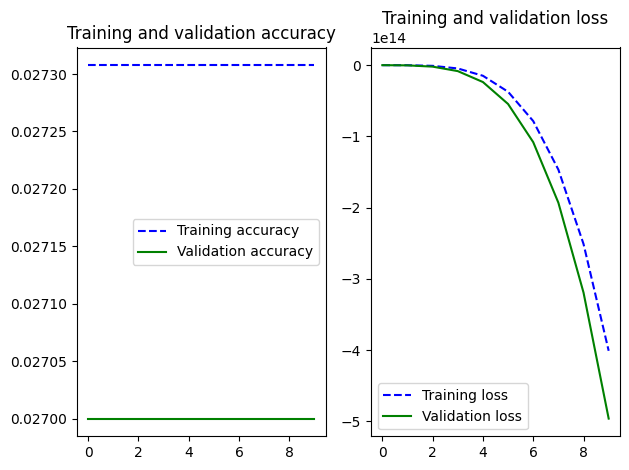

In [30]:
t_prediction_cnn_naif = Analyse_resultats(cnn_naif,cnn_naif_history)

Nous obtenons des résultats corrects, mais nous observons un cas clair de sur-apprentissage (overfitting) : le modèle est très performant sur les données d’entraînement, mais il a du mal à généraliser sur de nouvelles images.

Pour y remédier, nous allons mettre en place une nouvelle approche.

Une solution efficace pour contrer le sur-apprentissage est l’augmentation de données (data augmentation).
Cette technique consiste à transformer les images existantes pour générer de nouvelles images artificiellement : par exemple en appliquant des rotations, décalages, zooms, retournements, etc.
L’idée est d’augmenter la diversité du jeu de données, ce qui aide le réseau à apprendre des caractéristiques plus robustes et à mieux généraliser.

Nous entraînerons ensuite notre deuxième CNN sur ce jeu de données augmenté.

- On commence par générer le nouveau jeu de données :

In [9]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    img_dir,
    x_col ='Image',
    y_col ='SPECIES_NAME',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.


- Puis on initialise le nouveau CNN qu'on vient entrainer sur le nouveau jeu de données :

In [32]:
cnn_data_augmented = cnn_simple("cnn_data_augmented") # On initialise un nouveau réseau (identique au dernier)

cnn_data_augmented.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

t_learning_cnn_data_augmented, cnn_data_augmented_history, t_learning_cnn_data_augmented = Entrainement(cnn_data_augmented,epochs,train_generator_augmented) # on va l'entrainer avec les données augmentées cette fois

Entrainement de  cnn_data_augmented


/home/ecobicho/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.6752 - loss: 0.6148 - val_accuracy: 0.0270 - val_loss: -19.9415
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.6783 - loss: 0.5895 - val_accuracy: 0.0300 - val_loss: -14.7107
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.6892 - loss: 0.5715 - val_accuracy: 0.0300 - val_loss: -22.3970
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.6981 - loss: 0.5634 - val_accuracy: 0.0330 - val_loss: -25.0762
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.7081 - loss: 0.5577 - val_accuracy: 0.0330 - val_loss: -26.3213
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.7117 - loss: 0.5515 - val_accuracy: 0.0340 - val_loss: -22.6434
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.7221 - loss: 0.5399 - val_accuracy: 0.0330 - val_loss: -29.5582
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.7

- On observe que les performances sont meilleures :

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.0321 - loss: -28.3209
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.0310 - loss: -29.4883
Train accuracy: 0.0321153849363327
Validation accuracy: 0.03099999949336052
Time Prediction: 15.36 seconds


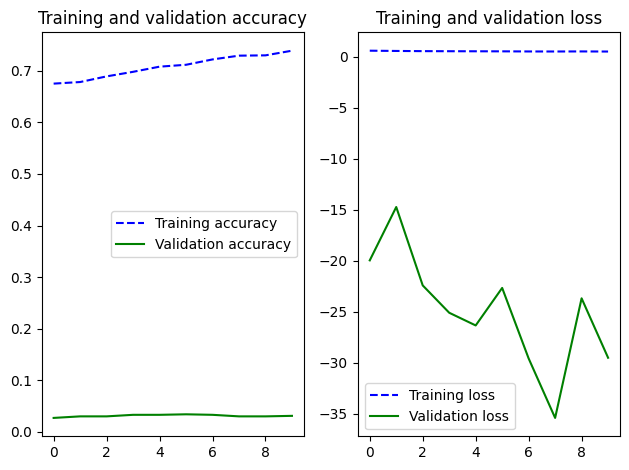

In [33]:
t_prediction_cnn_data_augmented = Analyse_resultats(cnn_data_augmented,cnn_data_augmented_history)

Cependant le modèle met beaucoup plus de temps à s'entrainer. On obtient des résultats corrects, mais si on veut faire mieux, il faudrait beaucoup plus de données à notre disposition, ainsi que beaucoup plus de temps.  

La dernière solution pour avoir une meilleure précision est d'utiliser le **Transfer Learning**. On va s'aider d'un réseau pré-entrainé (ici VGG16) et on va y accroché notre propre *MLP classifier*.
On peut aussi combiner cette approche avec l'augmentation de données. Nous avons vu dans le TP que c'est ce qui donne les meilleurs résultats, nous allons donc directement mettre en place cela. 

In [10]:
from tensorflow.keras.applications import VGG16 #on importe VGG16

#Contient la base de VGG
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)
#conv_base.summary()

I0000 00:00:1765455064.753067    4844 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13949 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


In [35]:
vgg_combined = Sequential(name="VGG16_data_augmented")
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False # On ne veut surtout pas toucher aux paramètres de VGG (on changera cela quand on fera le fine-tuning)
vgg_combined.summary()

Model: "VGG16_data_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

- On entraine notre réseau sur le jeu de données augmenté :

In [36]:
t_learning_vgg_combined_augmented, vgg_combined_history, t_learning_vgg_combined = Entrainement(vgg_combined,epochs,train_generator_augmented)

Entrainement de  VGG16_data_augmented
Epoch 1/10


2025-12-09 18:58:15.322935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_604', 52 bytes spill stores, 52 bytes spill loads

2025-12-09 18:58:15.352899: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_604', 8 bytes spill stores, 8 bytes spill loads



260/260 ━━━━━━━━━━━━━━━━━━━━ 34s 103ms/step - accuracy: 0.8065 - loss: 0.4147 - val_accuracy: 0.0270 - val_loss: -43.2135
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - accuracy: 0.8358 - loss: 0.3601 - val_accuracy: 0.0290 - val_loss: -54.5861
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.8544 - loss: 0.3257 - val_accuracy: 0.0270 - val_loss: -62.8790
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.8608 - loss: 0.3118 - val_accuracy: 0.0270 - val_loss: -69.4359
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.8679 - loss: 0.3040 - val_accuracy: 0.0280 - val_loss: -82.3685
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8600 - loss: 0.3170 - val_accuracy: 0.0270 - val_loss: -54.0649
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.8735 - loss: 0.2863 - val_accuracy: 0.0250 - val_loss: -76.1322
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.8771 - loss:

KeyboardInterrupt: 

In [ ]:
t_prediction_vgg_combined_augmented = Analyse_resultats(vgg_combined,vgg_combined_history)

Les résultats qu'on obtient avec le Transfer Learning sont bons.

### Fine Tuning
Pour améliorer encore davantage la précision, nous allons maintenant effectuer une étape de Fine Tuning.

Le Fine Tuning consiste à défiger certaines couches du modèle pré-entraîné afin de réentraîner partiellement le réseau sur notre propre jeu de données.
L’idée est de permettre au modèle d’adapter ses représentations internes (les filtres appris dans les couches profondes) à notre problème spécifique, tout en conservant les connaissances générales issues de l’entraînement initial.

In [ ]:
# On recrée la même architecture que vgg_combined mais on rename
vgg_finetuned = tf.keras.Sequential(name="VGG16_data_augmented_finetuned")
vgg_finetuned.add(Input(shape=(img_width, img_height, 3)))
vgg_finetuned.add(conv_base)
vgg_finetuned.add(Flatten())
vgg_finetuned.add(Dense(256, activation='relu'))
vgg_finetuned.add(Dense(1, activation='sigmoid'))

conv_base.trainable = True # On rend la base convolutive entraînable
for layer in conv_base.layers[:15]: # On bloque les 15 premières couches (celles qui apprennent des caractéristiques générales)
    layer.trainable = False

vgg_finetuned.set_weights(vgg_combined.get_weights()) # On copie les poids du modèle précédent

vgg_finetuned.summary()


In [ ]:
epochs = 5

vgg_finetuned.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-4), # Reduced learning rates to avoid smashing everything and risking overfitting
    metrics = ['accuracy']
)

t_learning_vgg_finetuned = time.time()
vgg_finetuned_history = vgg_finetuned.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_finetuned = time.time() - t_learning_vgg_finetuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_finetuned))

In [ ]:
Analyse_resultats(vgg_finetuned,vgg_finetuned_history)

On obtient maintenant de très bon résultats. Si on le souhaite, on pourrait continuer le fine-tuning mais ce n'est pas necessaire. 

### Comparaison des modèles

In [11]:
def Eval_Test(cnn):
    print("-------------",cnn.name,"-------------")
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    loss, acc = cnn.evaluate(test_generator)
    print(f"loss = {loss}")
    print(f"accuracy = {acc}\n")

In [ ]:
Eval_Test(cnn_naif)
Eval_Test(cnn_data_augmented)
Eval_Test(vgg_combined)
Eval_Test(vgg_finetuned)

Faire un petit texte qui parle des résultats

## 3- Classification Fine

Le but de cette partie est de déterminer pour chaque image la race de chat ou chien à laquelle elle appartient. Comme il y a beaucoup de classes (37) par rapport au nombre d'images d'entraînement, on s'attends à avoir des résultats peu satisfaisants.

### Mlp 

On va commencer par utiliser un multi-layer perceptron.

Il y a beaucoup trop de paramètres à apprendre par rapport à la quantité de données, de plus on perds touote l'information spatiale en faisant le flatten

On va réduire MASSIVEMENT la taille des images pour faciliter l'apprentissage des paramètres du réseau.

In [12]:
# On part du DataFrame complet : df qui a comme colonnes : mage, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME
data_breed = df[["Image", "BREED_NAME"]].copy() # On crée d’abord une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df_cf = train_test_split(data_breed, test_size=N_train, stratify=data_breed["BREED_NAME"])                    # On prend 5000
test_df_cf, validation_df_cf = train_test_split(temp_df, test_size=N_Validation, stratify=temp_df["BREED_NAME"])    # On prend 1000  dans ce qu'il reste N_test = N_total - (N_train+N_validation)

print("Train set :", train_df_cf.shape)
print("Validation set :", validation_df_cf.shape)
print("Test set :", test_df_cf.shape)
print("\n----Répartition des catégories----\n")
print("Train :", train_df_cf["BREED_NAME"].value_counts())
print("\nValidation :", validation_df_cf["BREED_NAME"].value_counts())
print("\nTest :", test_df_cf["BREED_NAME"].value_counts())

Train set : (5200, 2)
Validation set : (1000, 2)
Test set : (1149, 2)

----Répartition des catégories----

Train : BREED_NAME
Birman                        142
beagle                        142
Sphynx                        142
german_shorthaired            142
great_pyrenees                142
pomeranian                    142
British_Shorthair             142
saint_bernard                 142
shiba_inu                     142
english_setter                142
havanese                      142
miniature_pinscher            142
american_pit_bull_terrier     142
Ragdoll                       141
Siamese                       141
japanese_chin                 141
Bengal                        141
Persian                       141
Russian_Blue                  141
samoyed                       141
american_bulldog              141
pug                           141
boxer                         141
chihuahua                     141
yorkshire_terrier             141
wheaten_terrier         

In [13]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    target_size = (img_width, img_height),
    class_mode = 'sparse',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    class_mode = 'sparse',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df_cf,
    img_dir,
    x_col = 'Image',
    y_col = 'BREED_NAME',
    class_mode = 'sparse',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 37 classes.
Found 1000 validated image filenames belonging to 37 classes.
Found 1149 validated image filenames belonging to 37 classes.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

### 1) A multilayer simple perceptron

We need to flatten the images (size 150*150) to a vector shape

In [21]:
# Network definition

def mlp(nom, N_classes=37):
    mlp = Sequential(name=nom)
    mlp.add(Input(shape=(32, 32, 3)))
    mlp.add(Flatten())
    mlp.add(Dense(128, activation='relu'))
    mlp.add(Dropout(0.4))
    mlp.add(Dense(128, activation='relu'))
    mlp.add(Dropout(0.4))
    mlp.add(Dense(N_classes, activation='softmax'))
    return mlp

In [22]:
mlp_simple=mlp("mlp_simple")
mlp_simple.summary()  

Model: "mlp_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,629 (1.58 MB)

 Trainable params: 414,629 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.optimizers import Adam
import time
epochs = 10

def Entrainement_mlp(mlp,epochs,train_generator):
    print("Entrainement de ",mlp.name)
    mlp.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = Adam(),
        metrics = ['accuracy'])

    t_learning_mlp = time.time()
    
    mlp_history = mlp.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs
    )
    
    t_learning_mlp = time.time() - t_learning_mlp
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_mlp))
    
    return t_learning_mlp, mlp_history, t_learning_mlp

In [24]:
t_learning_mlp_naif, mlp_naif_history, t_learning_mlp_naif = Entrainement_mlp(mlp_simple,epochs,train_generator)

Entrainement de  mlp_simple
Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 3072, but received input with shape (None, 67500)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 150, 150, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [43]:
from sklearn.metrics import confusion_matrix

In [16]:
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(validation_generator, verbose=1)
    predict_cnn = cnn.predict(validation_generator)

    y_true = validation_generator.classes
    y_pred = np.argmax(predict_cnn, axis=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    plot_training_analysis(cnn_history)
    return t_prediction_cnn


260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.0612 - loss: 3.4462
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0660 - loss: 3.4552
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Train accuracy: 0.061153847724199295
Validation accuracy: 0.06599999964237213
Time Prediction: 16.27 seconds


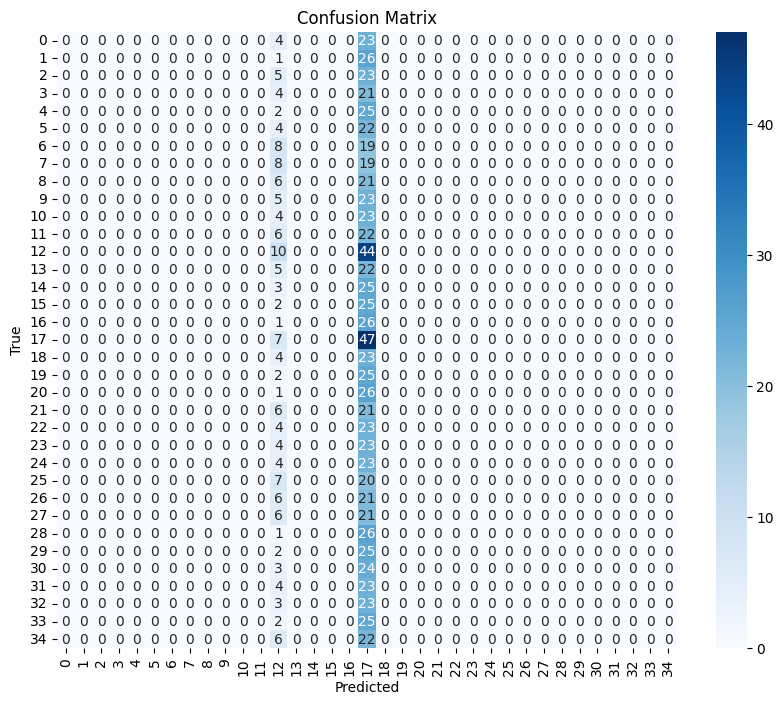

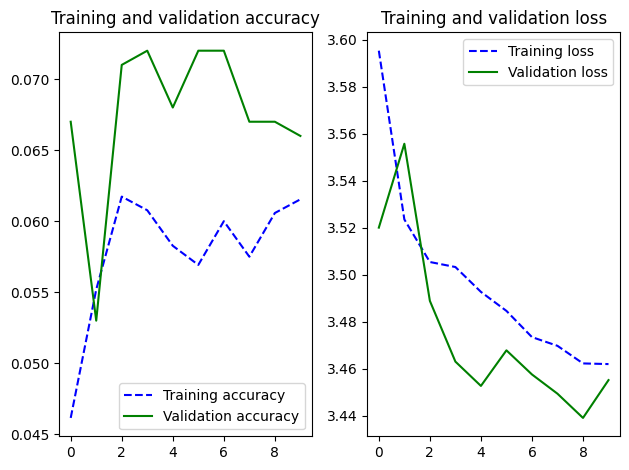

In [54]:
t_prediction_cnn_naif = Analyse_resultats(mlp_simple,mlp_naif_history)

### 2) CNN

In [17]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.layers import MaxPool2D, MaxPooling2D

In [ ]:
def CNN(nom,img_width,img_height, N_classes=37):
    model = Sequential(name=nom)
    model.add(Input(shape=(img_width, img_height, 3)))
    model.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu'))
    model.add(MaxPool2D(pool_size = 2, strides = 2))
    model.add(Conv2D(filters = 64, kernel_size = 3,strides = 1, activation = 'relu'))
    model.add(MaxPool2D(pool_size = 2, strides = 2))
    model.add(Flatten())
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = N_classes, activation = 'softmax'))
    return model

In [39]:
cnn=CNN("CNN",img_width,img_height)
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    21,233,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,290,723 (81.22 MB)

 Trainable params: 21,290,723 (81.22 MB)

 Non-trainable params: 0 (0.00 B)

Entrainement de  CNN
Epoch 1/10


2025-12-09 19:02:29.874487: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-09 19:02:29.874555: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-09 19:02:30.411999: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_578', 16 bytes spill stores, 16 bytes spill loads

2025-12-09 19:02:30.884411: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0287 - loss: nan

2025-12-09 19:02:44.940827: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.0273 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 9/10
260/260 

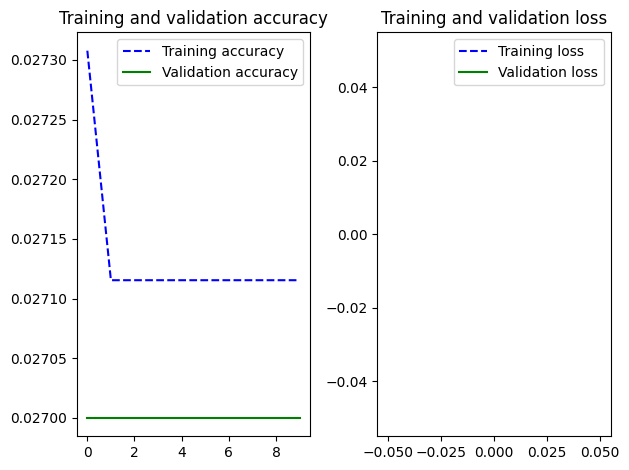

In [40]:
t_learning_cnn, cnn_history, _ = Entrainement_mlp(cnn, epochs, train_generator)
t_prediction_cnn_naif = Analyse_resultats(cnn, cnn_history)

### 3) Data augmentation

In [18]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df_cf,
    img_dir,
    x_col ='Image',
    y_col ='BREED_NAME',
    target_size=(img_width,img_height),
    class_mode = 'sparse',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 37 classes.


In [45]:
CNN_data_augmented = CNN("CNN_data_augmented",img_width,img_height) # On initialise un nouveau réseau (identique au dernier)

# on va l'entrainer avec les données augmentées cette fois
t_learning_cnn_data_augmented, cnn_data_augmented_history, _ = Entrainement_mlp(CNN_data_augmented, epochs, train_generator_augmented)

Entrainement de  CNN_data_augmented
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.0271 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - accuracy: 0.0271 - loss: nan - v

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0271 - loss: nan
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.0270 - loss: nan
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
Train accuracy: 0.027115384116768837
Validation accuracy: 0.027000000700354576
Time Prediction: 19.66 seconds


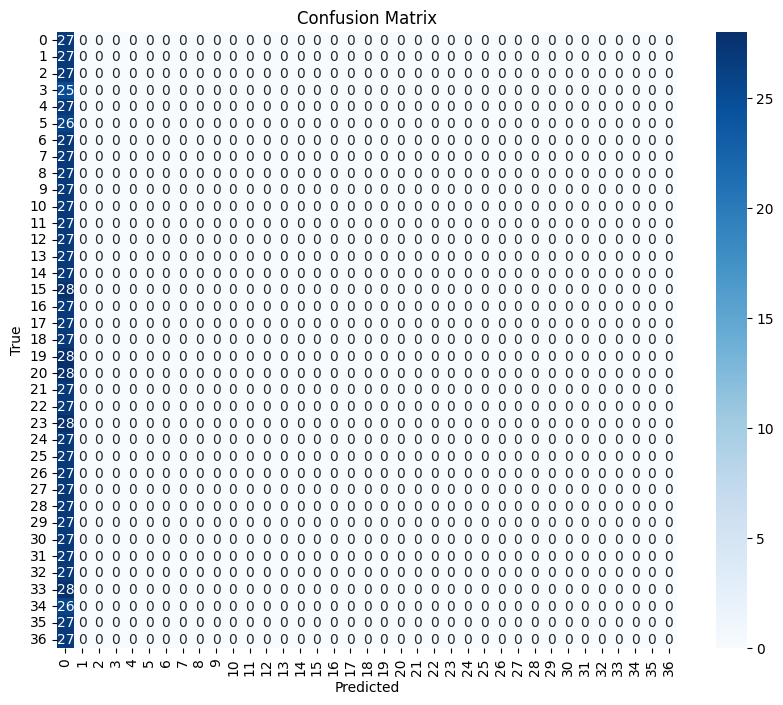

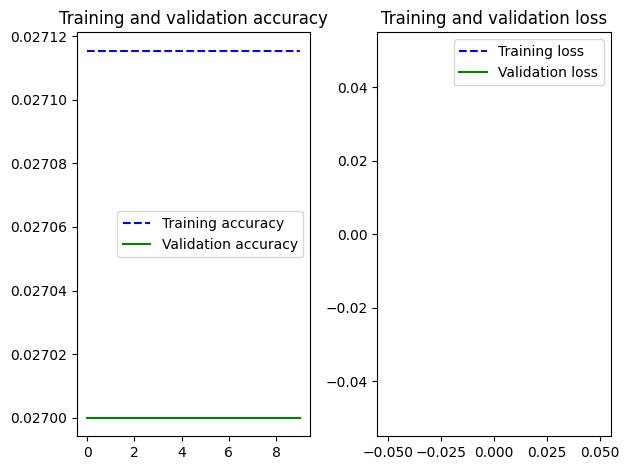

In [46]:
t_prediction_cnn_data_augmented = Analyse_resultats(CNN_data_augmented, cnn_data_augmented_history)

### 4) Transfer Learning : VGG16 + Data augmentation

In [19]:
from tensorflow.keras.applications import VGG16

#Contient la base de VGG
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)
#conv_base.summary()

In [51]:
vgg_combined = Sequential(name="VGG16_data_augmented")
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)

vgg_combined.add(Flatten())
vgg_combined.add(Dense(units = 256, activation = 'relu'))
vgg_combined.add(Dropout(0.5))
vgg_combined.add(Dense(units = 128, activation = 'relu'))
vgg_combined.add(Dense(units = 37, activation = 'softmax'))

conv_base.trainable = False # On ne veut surtout pas toucher aux paramètres de VGG (on changera cela quand on fera le fine-tuning)
vgg_combined.summary()

Model: "VGG16_data_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,849,765 (64.28 MB)

 Trainable params: 2,135,077 (8.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Entrainement de  VGG16_data_augmented
Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.0371 - loss: 3.6162 - val_accuracy: 0.0820 - val_loss: 3.4038
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.0550 - loss: 3.4411 - val_accuracy: 0.0820 - val_loss: 3.1672
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.0631 - loss: 3.3621 - val_accuracy: 0.1240 - val_loss: 3.0992
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.0658 - loss: 3.3221 - val_accuracy: 0.1170 - val_loss: 3.0500
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.0671 - loss: 3.3225 - val_accuracy: 0.1150 - val_loss: 2.9623
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.0713 - loss: 3.2702 - val_accuracy: 0.1020 - val_loss: 3.0041
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.0754 - loss: 3.2815 - val_accuracy: 0.1290 - val_loss: 2.8838
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 1

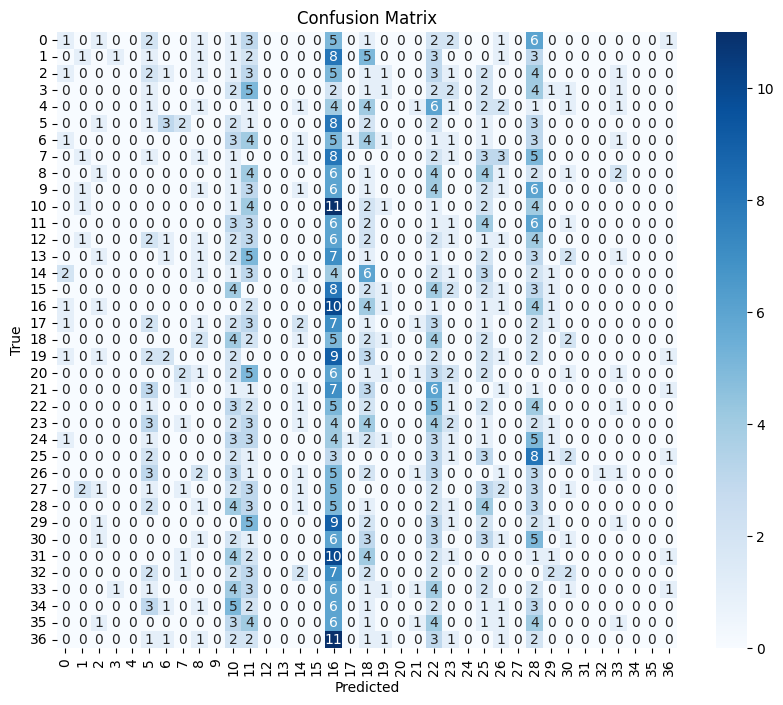

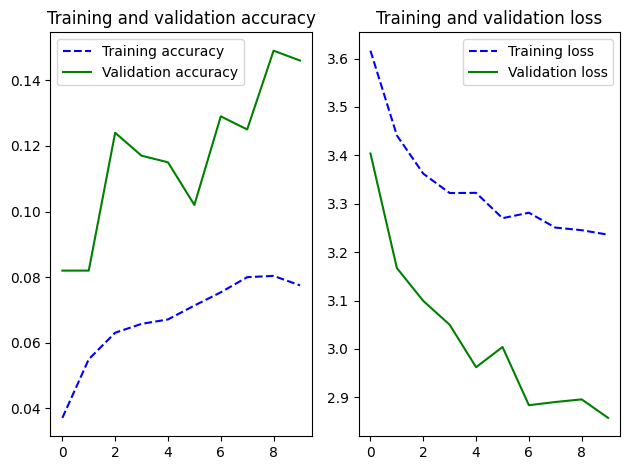

In [52]:
t_learning_vgg_combined_augmented, vgg_combined_history, t_learning_vgg_combined = Entrainement_mlp(vgg_combined,epochs,train_generator_augmented)
t_prediction_vgg_combined_augmented = Analyse_resultats(vgg_combined, vgg_combined_history)

### 5) Fine-tuning

In [53]:
# On recrée la même architecture que vgg_combined mais on rename
vgg_finetuned = tf.keras.Sequential(name="VGG16_data_augmented_finetuned")
vgg_finetuned.add(Input(shape=(img_width, img_height, 3)))
vgg_finetuned.add(conv_base)
vgg_finetuned.add(Flatten())
vgg_finetuned.add(Dense(units = 256, activation = 'relu'))
vgg_finetuned.add(Dropout(0.5))
vgg_finetuned.add(Dense(units = 128, activation = 'relu'))
vgg_finetuned.add(Dense(units = 37, activation = 'softmax'))

conv_base.trainable = True # On rend la base convolutive entraînable
for layer in conv_base.layers[:15]: # On bloque les 15 premières couches (celles qui apprennent des caractéristiques générales)
    layer.trainable = False

vgg_finetuned.set_weights(vgg_combined.get_weights()) # On copie les poids du modèle précédent

vgg_finetuned.summary()

Model: "VGG16_data_augmented_finetuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,849,765 (64.28 MB)

 Trainable params: 9,214,501 (35.15 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [20]:
epochs = 20

def Entrainement_mlp2(mlp,epochs,train_generator,lr=1e-4):
    print("Entrainement de ",mlp.name)
    mlp.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = Adam(learning_rate=lr),
        metrics = ['accuracy'])

    t_learning_mlp = time.time()
    
    mlp_history = mlp.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs
    )
    
    t_learning_mlp = time.time() - t_learning_mlp
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_mlp))
    
    return t_learning_mlp, mlp_history, t_learning_mlp

Entrainement de  VGG16_data_augmented_finetuned
Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 0.6794 - loss: 1.0447 - val_accuracy: 0.6110 - val_loss: 1.4550
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.6944 - loss: 0.9817 - val_accuracy: 0.6390 - val_loss: 1.2838
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.7102 - loss: 0.9135 - val_accuracy: 0.6750 - val_loss: 1.2642
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.7308 - loss: 0.8783 - val_accuracy: 0.6820 - val_loss: 1.0997
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.7358 - loss: 0.8779 - val_accuracy: 0.6750 - val_loss: 1.1761
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.7625 - loss: 0.7710 - val_accuracy: 0.6910 - val_loss: 1.1684
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.7708 - loss: 0.7464 - val_accuracy: 0.6890 - val_loss: 1.1606
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━

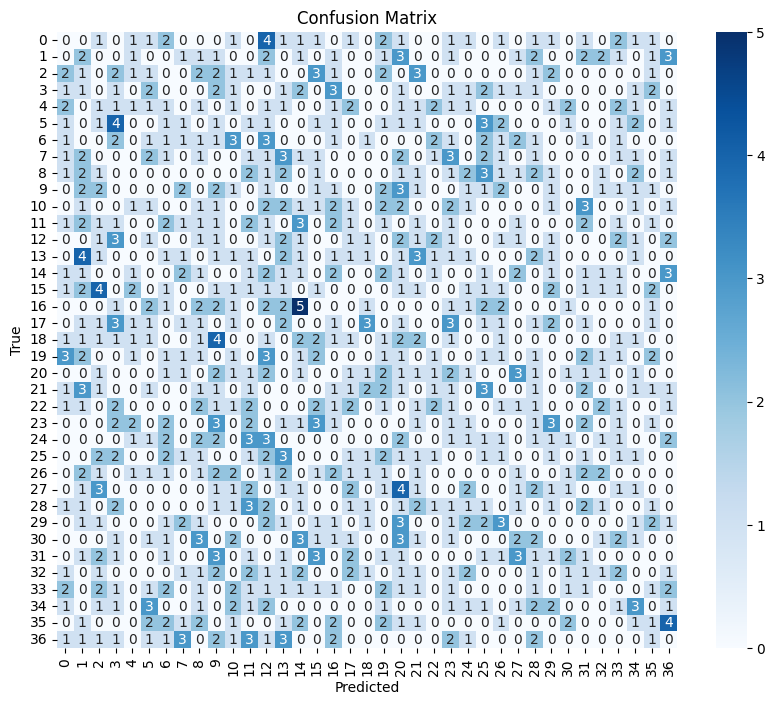

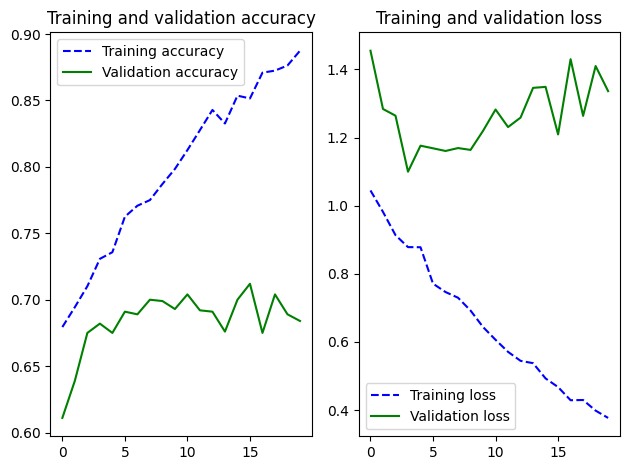

17.333744287490845

In [59]:
t_learning_vgg_finetuned_augmented, vgg_finetuned_history, t_learning_vgg_finetuned = Entrainement_mlp2(vgg_finetuned,epochs,train_generator_augmented,lr=1e-4)
Analyse_resultats(vgg_finetuned,vgg_finetuned_history)

## 4- Segmentation des animaux

Using a U-net network

Data loader pour les images et masques

In [21]:
!pip install tensorflow.keras

In [7]:
# On part du DataFrame complet : df qui a comme colonnes : Image, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME
data_segmentation = df[["Image"]].copy()  # On crée une version simplifiée pour la séparation

N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df_seg = train_test_split(data_segmentation, test_size=N_train, random_state=42)
test_df_seg, validation_df_seg = train_test_split(temp_df, test_size=N_Validation, random_state=42)

print("Train set :", train_df_seg.shape)
print("Validation set :", validation_df_seg.shape)
print("Test set :", test_df_seg.shape)

Train set : (5200, 1)
Validation set : (1000, 1)
Test set : (1149, 1)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import random

class SegmentationDataLoader(Sequence):
    def __init__(self, df, img_dir, mask_dir,
                 img_size=(128,128), batch_size=20,
                 augment=False):

        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx*self.batch_size : (idx+1)*self.batch_size]

        X = []
        Y = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, row["Image"])
            mask_path = os.path.join(self.mask_dir,
                                     row["Image"].replace(".jpg", ".png"))

            # Load image
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0

            # Load mask (trimap)
            mask = load_img(mask_path,
                            target_size=self.img_size,
                            color_mode="grayscale")
            mask = img_to_array(mask).astype(np.int32)

            # Convert 1,2,3 -> 0,1 (binarisation: animal vs fond)
            mask = np.where(mask == 1, 1, 0)

            # Data augmentation synchronisée
            if self.augment:
                if random.random() < 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)

            X.append(img)
            Y.append(mask)

        return np.array(X), np.array(Y)

In [9]:
# Créer les SegmentationDataLoaders
batch_size = 20
img_width = 128
img_height = 128
mask_dir = "./oxford-iiit-pet/annotations/trimaps"

train_loader_seg = SegmentationDataLoader(
    train_df_seg,
    img_dir,
    mask_dir,
    img_size=(img_width, img_height),
    batch_size=batch_size,
    augment=True
)

val_loader_seg = SegmentationDataLoader(
    validation_df_seg,
    img_dir,
    mask_dir,
    img_size=(img_width, img_height),
    batch_size=batch_size,
    augment=False
)

test_loader_seg = SegmentationDataLoader(
    test_df_seg,
    img_dir,
    mask_dir,
    img_size=(img_width, img_height),
    batch_size=batch_size,
    augment=False
)

### U-net model:

In [10]:
from tensorflow.keras.layers import BatchNormalization, UpSampling2D, Concatenate

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# On extrait les couches de MobileNetV2 pour la partie encodeur du U-Net
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4 (Bottleneck)
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# L'encodeur est pré-entrainé sur ImageNet. Pour l'instant on fixe les poids
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

# Le décodeur contient des couches de upsampling + Conv2D
# Fonction pour créer les blocs de décoder
def upsample_block(filters):
    return tf.keras.Sequential([
        UpSampling2D((2, 2)),
        Conv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization()
    ])

up_stack = [
    upsample_block(512),  # 4x4 -> 8x8
    upsample_block(256),  # 8x8 -> 16x16
    upsample_block(128),  # 16x16 -> 32x32
    upsample_block(64),   # 32x32 -> 64x64
]

def unet_model(output_channels: int = 1):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # Encoder
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])  # on enlève le bottleneck
    
    # Decoder avec skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])
    
    # Dernière couche : upsampling + sigmoid pour segmentation binaire
    x = UpSampling2D((2, 2))(x)  # 64x64 -> 128x128
    last = Conv2D(output_channels, 3, activation='sigmoid', padding='same')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=last)


2025-12-11 14:33:28.916966: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-12-11 14:33:28.916996: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-12-11 14:33:28.917001: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: insa-21263
2025-12-11 14:33:28.917005: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: insa-21263
2025-12-11 14:33:28.917111: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: 580.95.5
2025-12-11 14:33:28.917123: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:194] kernel reported version is: 580.95.5
2

In [11]:
# Créer et compiler le U-Net pour la segmentation binaire
Unet = unet_model(output_channels=1)  # 1 canal pour foreground vs background
Unet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Unet.summary()

# Entraîner avec les loaders de segmentation
epochs = 10
unet_history = Unet.fit(
    train_loader_seg,
    validation_data=val_loader_seg,
    epochs=epochs,
    verbose=1
)

# Évaluer sur l'ensemble de validation
val_loss, val_acc = Unet.evaluate(val_loader_seg)
print(f"\nValidation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  3,838,976 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  3,099,136 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    664,832 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    194,176 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ concatenate_3[0]… │
│ (UpSampling2D)      │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      1,441 │ up_sampling2d_4[… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,640,545 (36.78 MB)

 Trainable params: 7,794,721 (29.73 MB)

 Non-trainable params: 1,845,824 (7.04 MB)

/home/ecobicho/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-12-11 14:33:35.976117: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


260/260 ━━━━━━━━━━━━━━━━━━━━ 188s 703ms/step - accuracy: 0.9203 - loss: 0.1944 - val_accuracy: 0.9379 - val_loss: 0.1575
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 178s 684ms/step - accuracy: 0.9420 - loss: 0.1449 - val_accuracy: 0.9416 - val_loss: 0.1499
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 181s 695ms/step - accuracy: 0.9471 - loss: 0.1310 - val_accuracy: 0.9395 - val_loss: 0.1534
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 180s 692ms/step - accuracy: 0.9509 - loss: 0.1212 - val_accuracy: 0.9457 - val_loss: 0.1419
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 179s 689ms/step - accuracy: 0.9540 - loss: 0.1128 - val_accuracy: 0.9428 - val_loss: 0.1554
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 179s 686ms/step - accuracy: 0.9564 - loss: 0.1062 - val_accuracy: 0.9482 - val_loss: 0.1360
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 178s 686ms/step - accuracy: 0.9587 - loss: 0.1003 - val_accuracy: 0.9491 - val_loss: 0.1368
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 183s 704ms/step - accuracy: 0.9610 - loss: 0.09

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


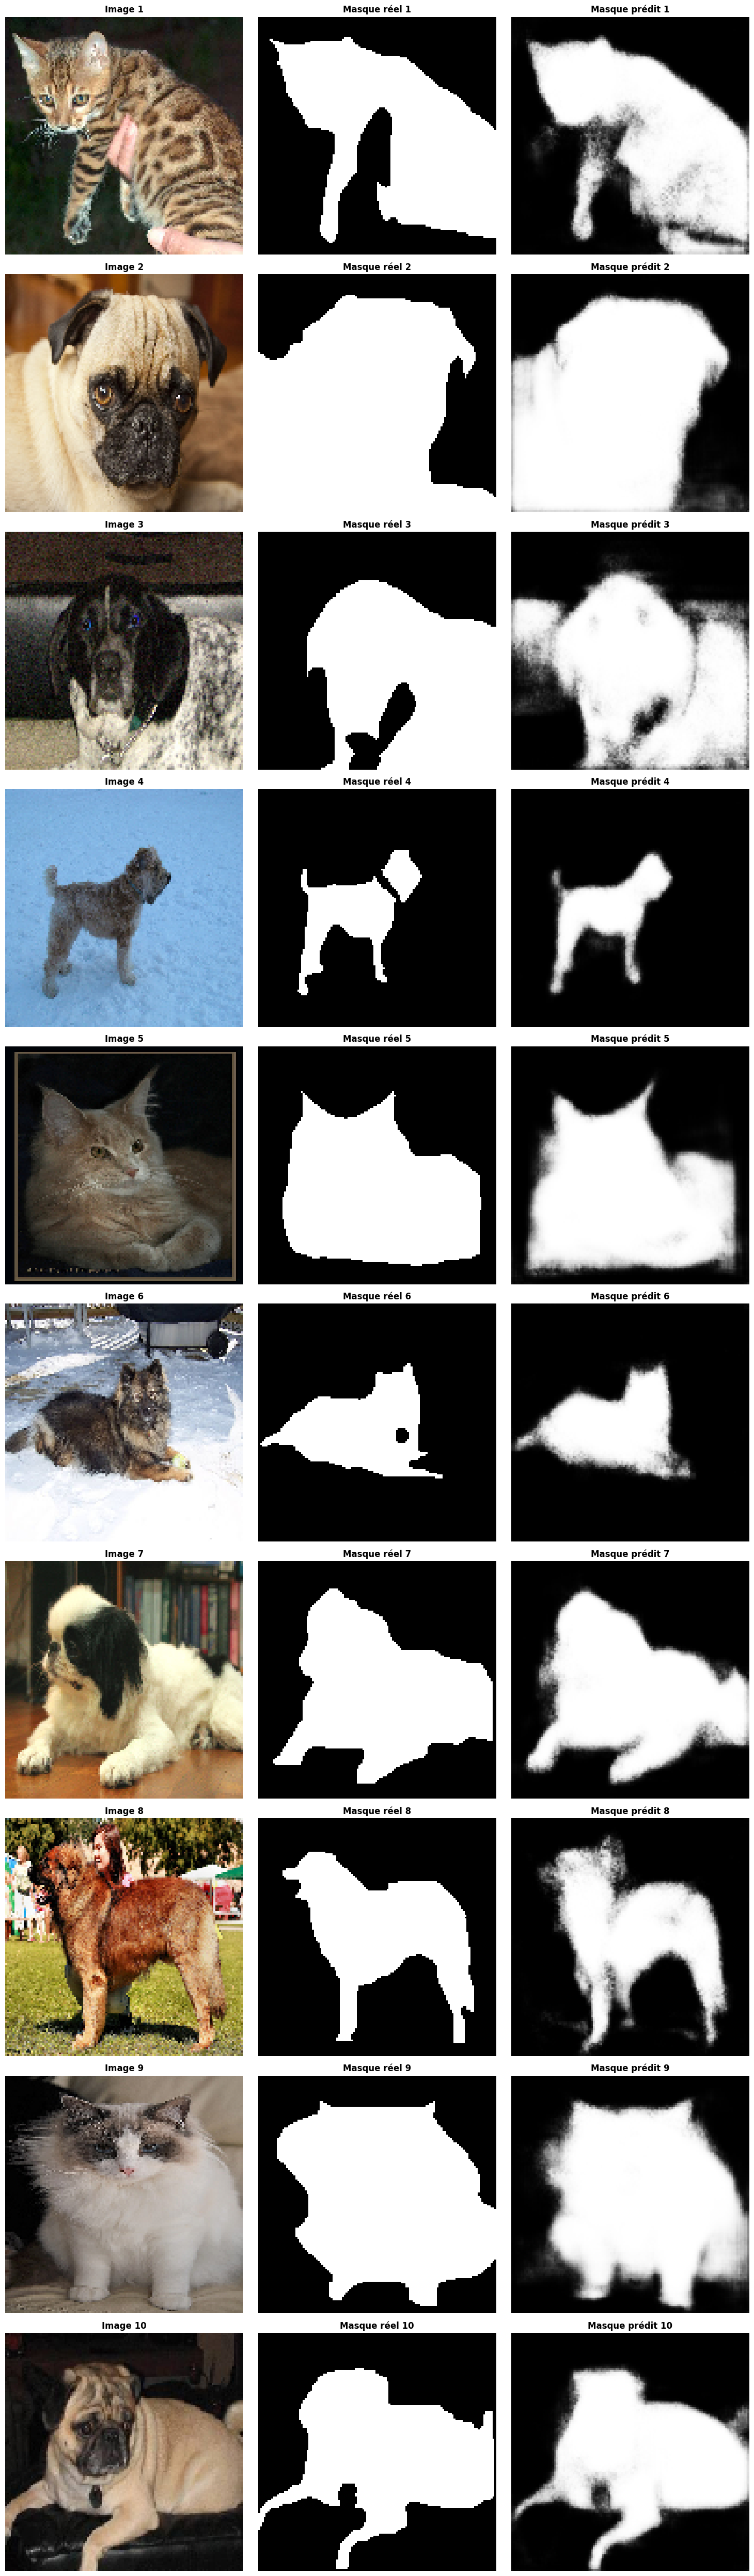

Visualisation des prédictions de segmentation terminée!


In [14]:
# Visualiser les masques prédits sur quelques exemples
num_examples = 10
fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5*num_examples))

# Prendre num_examples du validation loader
for i in range(num_examples):
    X_batch, y_batch = val_loader_seg[i]
    
    # Prédire les masques
    y_pred = Unet.predict(X_batch[:1])  # Prendre la première image du batch
    
    # Récupérer les valeurs
    img = X_batch[0]
    mask_true = y_batch[0]
    mask_pred = y_pred[0]
    
    # Afficher l'image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Image {i+1}', fontweight='bold')
    axes[i, 0].axis('off')
    
    # Afficher le masque réel
    axes[i, 1].imshow(mask_true[:,:,0], cmap='gray')
    axes[i, 1].set_title(f'Masque réel {i+1}', fontweight='bold')
    axes[i, 1].axis('off')
    
    # Afficher le masque prédit
    axes[i, 2].imshow(mask_pred[:,:,0], cmap='gray')
    axes[i, 2].set_title(f'Masque prédit {i+1}', fontweight='bold')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print("Visualisation des prédictions de segmentation terminée!")


In [15]:
# Calculer des métriques plus pertinentes pour la segmentation
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

all_y_true = []
all_y_pred = []

# Prédire sur tous les batches de validation
for i in range(len(val_loader_seg)):
    X_batch, y_batch = val_loader_seg[i]
    y_pred_batch = Unet.predict(X_batch, verbose=0)
    
    # Binariser à 0.5
    y_pred_binary = (y_pred_batch > 0.5).astype(np.int32)
    
    # Aplatir et accumuler
    all_y_true.extend(y_batch.flatten())
    all_y_pred.extend(y_pred_binary.flatten())

all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Calculer les métriques
iou = jaccard_score(all_y_true, all_y_pred)
precision = precision_score(all_y_true, all_y_pred, zero_division=0)
recall = recall_score(all_y_true, all_y_pred, zero_division=0)
f1 = f1_score(all_y_true, all_y_pred, zero_division=0)

# Dice coefficient
dice = 2 * (np.sum(all_y_pred * all_y_true)) / (np.sum(all_y_pred) + np.sum(all_y_true) + 1e-8)

print("="*50)
print("MÉTRIQUES DE SEGMENTATION")
print("="*50)
print(f"Accuracy pixel-wise:  {np.mean(all_y_true == all_y_pred):.4f} (défaut Keras)")
print(f"IoU (Jaccard):        {iou:.4f}")
print(f"Dice coefficient:     {dice:.4f}")
print(f"Precision (animal):   {precision:.4f}")
print(f"Recall (animal):      {recall:.4f}")
print(f"F1-score:             {f1:.4f}")
print("="*50)
print("\nInterprétation:")
print(f"- IoU/Dice proches de 1 = bon overlap entre prédiction et réalité")
print(f"- Precision = {precision:.4f} : {precision*100:.1f}% des pixels prédits comme animaux sont vrais")
print(f"- Recall = {recall:.4f} : {recall*100:.1f}% des vrais pixels animaux sont détectés")


MÉTRIQUES DE SEGMENTATION
Accuracy pixel-wise:  0.9506 (défaut Keras)
IoU (Jaccard):        0.8456
Dice coefficient:     0.9163
Precision (animal):   0.9132
Recall (animal):      0.9195
F1-score:             0.9163

Interprétation:
- IoU/Dice proches de 1 = bon overlap entre prédiction et réalité
- Precision = 0.9132 : 91.3% des pixels prédits comme animaux sont vrais
- Recall = 0.9195 : 91.9% des vrais pixels animaux sont détectés


OPTIMISATION DU SEUIL DE SEGMENTATION

✓ Seuil optimal pour IoU: 0.44 (IoU = 0.8463)
✓ Seuil optimal pour Dice: 0.44 (Dice = 0.9168)
✓ Seuil optimal pour F1-score: 0.44 (F1 = 0.9168)

Seuil par défaut: 0.50
  - IoU = 0.8461
  - Dice = 0.9166
  - F1 = 0.9166

ROC AUC Score: 0.9870


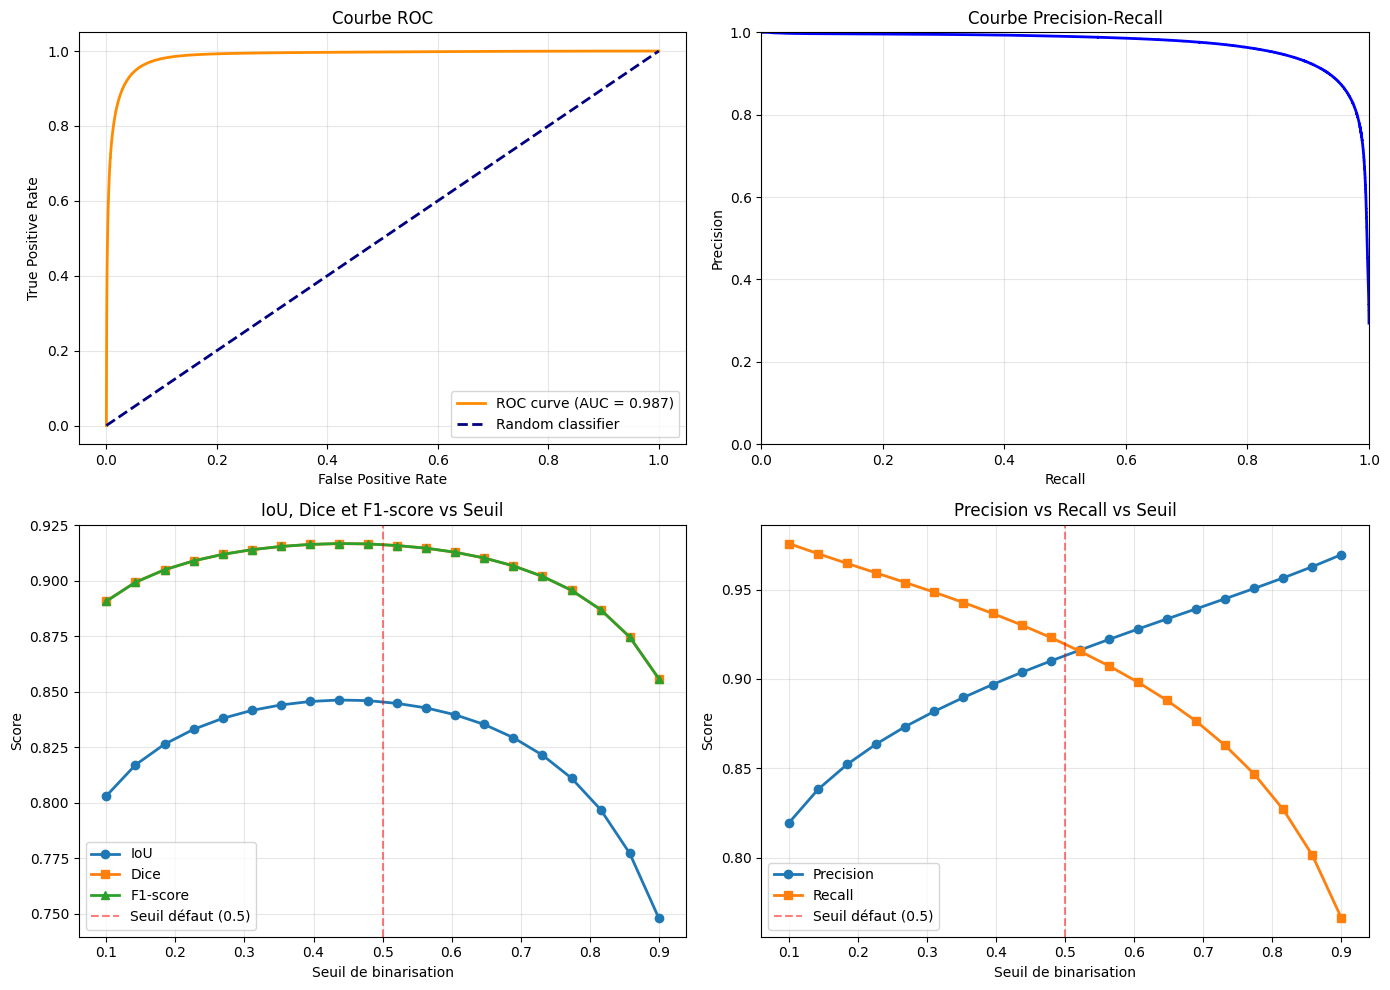


TABLEAU RÉCAPITULATIF DES MÉTRIQUES PAR SEUIL
 threshold      iou     dice  precision   recall       f1
  0.100000 0.803206 0.890864   0.819490 0.975858 0.890864
  0.142105 0.817121 0.899358   0.838188 0.970159 0.899358
  0.184211 0.826443 0.904976   0.852191 0.964732 0.904976
  0.226316 0.833145 0.908979   0.863586 0.959407 0.908979
  0.268421 0.838078 0.911907   0.873342 0.954035 0.911907
  0.310526 0.841655 0.914020   0.881888 0.948582 0.914020
  0.352632 0.844111 0.915467   0.889651 0.942825 0.915467
  0.394737 0.845668 0.916381   0.896882 0.936747 0.916381
  0.436842 0.846339 0.916775   0.903677 0.930259 0.916775
  0.478947 0.846064 0.916614   0.910063 0.923260 0.916614
  0.521053 0.844805 0.915875   0.916142 0.915607 0.915875
  0.563158 0.842790 0.914689   0.922125 0.907372 0.914689
  0.605263 0.839682 0.912856   0.927948 0.898246 0.912856
  0.647368 0.835316 0.910270   0.933644 0.888037 0.910270
  0.689474 0.829384 0.906736   0.939249 0.876398 0.906736
  0.731579 0.821519 0.902

In [16]:
# Optimisation du seuil de segmentation avec ROC et Precision-Recall curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score

# Prédire les probabilités (sans binarisation) sur tous les batches
all_y_true_raw = []
all_y_pred_raw = []  # Probabilités continues [0, 1]

for i in range(len(val_loader_seg)):
    X_batch, y_batch = val_loader_seg[i]
    y_pred_batch = Unet.predict(X_batch, verbose=0)
    
    all_y_true_raw.extend(y_batch.flatten())
    all_y_pred_raw.extend(y_pred_batch.flatten())

all_y_true_raw = np.array(all_y_true_raw)
all_y_pred_raw = np.array(all_y_pred_raw)

# Calculer la courbe ROC
fpr, tpr, thresholds_roc = roc_curve(all_y_true_raw, all_y_pred_raw)
roc_auc = auc(fpr, tpr)

# Calculer la courbe Precision-Recall
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(all_y_true_raw, all_y_pred_raw)

# Tester différents seuils pour optimiser les métriques
test_thresholds = np.linspace(0.1, 0.9, 20)
results = []

for thresh in test_thresholds:
    y_pred_binary = (all_y_pred_raw > thresh).astype(np.int32)
    
    iou = jaccard_score(all_y_true_raw, y_pred_binary)
    dice = 2 * (np.sum(y_pred_binary * all_y_true_raw)) / (np.sum(y_pred_binary) + np.sum(all_y_true_raw) + 1e-8)
    precision = precision_score(all_y_true_raw, y_pred_binary, zero_division=0)
    recall = recall_score(all_y_true_raw, y_pred_binary, zero_division=0)
    f1 = f1_score(all_y_true_raw, y_pred_binary, zero_division=0)
    
    results.append({
        'threshold': thresh,
        'iou': iou,
        'dice': dice,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)

# Trouver les seuils optimaux selon différents critères
best_iou_idx = results_df['iou'].idxmax()
best_dice_idx = results_df['dice'].idxmax()
best_f1_idx = results_df['f1'].idxmax()

print("="*60)
print("OPTIMISATION DU SEUIL DE SEGMENTATION")
print("="*60)
print(f"\n✓ Seuil optimal pour IoU: {results_df.loc[best_iou_idx, 'threshold']:.2f} (IoU = {results_df.loc[best_iou_idx, 'iou']:.4f})")
print(f"✓ Seuil optimal pour Dice: {results_df.loc[best_dice_idx, 'threshold']:.2f} (Dice = {results_df.loc[best_dice_idx, 'dice']:.4f})")
print(f"✓ Seuil optimal pour F1-score: {results_df.loc[best_f1_idx, 'threshold']:.2f} (F1 = {results_df.loc[best_f1_idx, 'f1']:.4f})")
print(f"\nSeuil par défaut: 0.50")
default_idx = (results_df['threshold'] - 0.5).abs().idxmin()
print(f"  - IoU = {results_df.loc[default_idx, 'iou']:.4f}")
print(f"  - Dice = {results_df.loc[default_idx, 'dice']:.4f}")
print(f"  - F1 = {results_df.loc[default_idx, 'f1']:.4f}")
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC Curve
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Courbe ROC')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(alpha=0.3)

# Precision-Recall Curve
axes[0, 1].plot(recall_curve, precision_curve, color='blue', lw=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Courbe Precision-Recall')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])

# Métriques vs Seuil
axes[1, 0].plot(results_df['threshold'], results_df['iou'], marker='o', label='IoU', linewidth=2)
axes[1, 0].plot(results_df['threshold'], results_df['dice'], marker='s', label='Dice', linewidth=2)
axes[1, 0].plot(results_df['threshold'], results_df['f1'], marker='^', label='F1-score', linewidth=2)
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Seuil défaut (0.5)')
axes[1, 0].set_xlabel('Seuil de binarisation')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('IoU, Dice et F1-score vs Seuil')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Precision vs Recall
axes[1, 1].plot(results_df['threshold'], results_df['precision'], marker='o', label='Precision', linewidth=2)
axes[1, 1].plot(results_df['threshold'], results_df['recall'], marker='s', label='Recall', linewidth=2)
axes[1, 1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Seuil défaut (0.5)')
axes[1, 1].set_xlabel('Seuil de binarisation')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Precision vs Recall vs Seuil')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("\n" + "="*60)
print("TABLEAU RÉCAPITULATIF DES MÉTRIQUES PAR SEUIL")
print("="*60)
print(results_df.to_string(index=False))


## 5- Analyse comparative